In [ ]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import plotly
import plotly.graph_objs as go

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [ ]:
import collections

In [ ]:
!pip install apimoex

In [ ]:
import requests
import apimoex

session = requests.Session()

In [ ]:
df = pd.DataFrame(apimoex.get_board_history(session, 'MOEX')).dropna()
df = df[-5000:]
df = df.reset_index(drop=True)
print(df.head())

  BOARDID   TRADEDATE  CLOSE  VOLUME       VALUE
0    TQBR  2013-04-04  48.13  210880  10148463.2
1    TQBR  2013-04-05  47.69  345780  16698661.4
2    TQBR  2013-04-08  47.54  227840  10889442.1
3    TQBR  2013-04-09  47.48  425000  20233800.0
4    TQBR  2013-04-10  46.96  140100   6624780.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['CLOSE'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции MOEX'
            ))
fig.show()

In [ ]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])


        if noise:
            # add a noise
            self.data += np.random.normal(0, 0.05, size = self.data.shape)*self.data
        if normalize:
            # minmax normalization
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        We return the derivatives of a separate window in our selection
        and remove the zeros at the beginning
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 1, fee=0.001):
        """
        0 => long   1 => short
        """
        if action == -1:
            action = -3
        elif action == 1:
            action = 1

        # We pull out the current price
        price_now = self.data[action_time]
        # We pull out the next price
        price_reward = self.data[reward_time]
        # We get the difference
        price_diff = (price_reward - price_now)
        # We add the following number to the portfolio:
        # Delta of currency change * buy/sell/hold * purchase ratio  fee -- broker fee
        reward = price_diff * action * coef*(1-fee)

        return reward

We don't want to study trading, we need to develop intuition to predict the price. Thus, a small simple NN is needed.

In [ ]:
# define the nn architecture
class BioLinear(nn.Module):
    # BioLinear is just Linear, but each neuron comes with coordinates.
    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1):
        super(BioLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold # in_fold is the number of folds applied to input vectors. It only affects coordinates, not computations.
        self.out_fold = out_fold # out_fold is the number of folds applied to output vectors. It only affects coordinates, not computations.
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        #compute in_cor, shape: (in_dim)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        self.in_coordinates = torch.tensor(list(np.linspace(1/(2*in_dim_fold), 1-1/(2*in_dim_fold), num=in_dim_fold))*in_fold, dtype=torch.float) # place input neurons in 1D Euclidean space
        self.out_coordinates = torch.tensor(list(np.linspace(1/(2*out_dim_fold), 1-1/(2*out_dim_fold), num=out_dim_fold))*out_fold, dtype=torch.float) # place output neurons in 1D Euclidean space
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x.clone()
        self.output = self.linear(x).clone()
        return self.output


class BioMLP(nn.Module):
    # BioMLP is just MLP, but each neuron comes with coordinates.
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1

        linear_list = []
        for i in range(self.depth):
            if i == 0:
                linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=1))

            else:
                linear_list.append(BioLinear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.1 # distance between two nearby layers
        self.in_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 10 # the number of important neurons (used in Swaps)
        self.token_embedding = token_embedding
        self.n_parameters = sum(p.numel() for p in self.parameters())
        self.original_params = None

    def forward(self, x):
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)


        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=1.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        # bias_penalize = True penalizes biases, otherwise doesn't penalize biases
        # no_penalize_last = True means do not penalize last linear layer, False means penalize last layer.
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0))
            cc += torch.sum(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.sum(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.sum(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        # Given a weight matrix, swap the j^th and k^th neuron in inputs/outputs when swap_type = "in"/"out"
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        # Given a bias vector, swap the j^th and k^th neuron.
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : incoming weights, outgoing weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        # in the ith layer (of neurons), get the top k important neurons (have large weight connections with other neurons)
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)

    def plot(self):
        fig, ax = plt.subplots(figsize=(3,3))
        #ax = plt.gca()
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        linears = self.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight
            p_shp = p.shape
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num):
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=1*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                else:
                    for j in range(fold_num):
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=0.5*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")

        ax.axis('off')


    def thresholding(self, threshold, checkpoint = True):
        # snap too small weights (smaller than threshold) to zero. Useful for pruning.
        num = 0
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            for param in self.parameters():
                num += torch.sum(torch.abs(param)>threshold)
                param.data = param*(torch.abs(param)>threshold)
        return num

    def intervening(self, i, pos, value, ptype="weight", checkpoint = True):
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            if ptype == "weight":
                self.linears[i].linear.weight[pos] = value
            elif ptype == "bias":
                self.linears[i].linear.bias[pos] = value

    def revert(self):
        with torch.no_grad():
            for param, original_param in zip(self.parameters(), self.original_params):
                param.data.copy_(original_param.data)

In [ ]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Creating an instance of the model
        self.model = BioMLP(shp=[state_shape,32,16,action_shape])

        # Let's create an error function
        self.criterion = nn.SmoothL1Loss()
        # Let's add an optimizer
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-4, weight_decay=0.00)

    def save_experience(self, current_state, action, reward, next_state):
        """A method for saving previous experimental data"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size, epoch):
        """A method for optimizing training data"""
        # Creating a fixed selection from the added events
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # We are going through only those elements that were added to the selection

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # We get a forecast for the following state
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # we get a forecast for the current state
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # The Bellman equation
        for i in range(len(indices_sampled)):
            # we enter it in the Q table for training
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        reg = self.model.get_cc(weight_factor=1.)
        if epoch < 100:
          lambd = 0.000
        else: lambd = 0.003
        loss = self.criterion(outputs, torch.Tensor(current_q_values)) + lambd*reg
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return reg

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [ ]:
# number of epochs
epochs = 200
# The significance of the reward is one step ahead
gamma = 0.97
# initial epsilon
epsilon = 1.0
# epsilon_decay
alpha_e = 0.97

In [ ]:
# dataset size
DATASET_LENGTH = len(df['CLOSE'])
# The size of the window from which the previous data will be taken
WINDOW_SHAPE = 30
# Previous data step
REWARD_TIME = 1
# number of action
ACTIONS_SHAPE = 2
# Sample size
SAMPLE_SIZE = 50
EXP_SIZE = 64
# test size
SIZE_test = 200

In [ ]:
action_to_backtest_action = {
    1: 1,  # buy
    0: -1,  # sell
}

In [ ]:
train_dataset = np.array(df['CLOSE'][:-SIZE_test])
test_dataset = np.array(df['CLOSE'][-SIZE_test:])

In [ ]:
# We prescribe a new environment and transmit data on the closing price
set_random_seed(42)
environment = Environment(train_dataset, test_dataset, normalize = False, noise = False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE, EXP_SIZE)

In [ ]:
set_random_seed(42)
progress = []


for i in range(epochs):

    learning_progress = []
    reg = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Get the current state. Derivatives in a separate interval
        # The current Y on the graph and the previous WINDOW_SHAPE steps
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # We get a prediction for this state through the model
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Select an action for the current state
        # Depending on the length of the epsilon, we choose a random action
        # or real ones according to predictions
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. We receive a reward for the selected action
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. We get the future state. Derivatives in the future interval
        # The current Y + 1 on the graph and the previous WINDOW_SHAPE steps
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. We save all the received data of the agent
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. As soon as the number of previously received samples has exceeded
        # for what is necessary, we begin to train the network
        if j > 2*SAMPLE_SIZE:
            reg.append(agent.replay_experience(gamma, SAMPLE_SIZE,i).detach().numpy())

    # With each step, we decrease the epsilon so that the bot begins to act
    # according to his own forecasts, he stopped studying the environment
    epsilon = epsilon*alpha_e

    print('Epoch', i, '...', np.mean(learning_progress),'...','reg',np.mean(reg))
    progress.append(np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... 0.07230542447629534 ... reg 75.49746
Epoch 1 ... -0.009780727673649446 ... reg 81.15495
Epoch 2 ... 0.026430727673649453 ... reg 82.029175
Epoch 3 ... 0.02390477398015439 ... reg 86.48898
Epoch 4 ... 0.039996714443219436 ... reg 90.44763
Epoch 5 ... 0.056228169790518166 ... reg 93.03353
Epoch 6 ... 0.042232624035281156 ... reg 96.94631
Epoch 7 ... 0.06994101433296587 ... reg 97.5287
Epoch 8 ... 0.06031081587651593 ... reg 101.49472
Epoch 9 ... 0.06396390297684663 ... reg 102.80561
Epoch 10 ... 0.0735206725468576 ... reg 103.21918
Epoch 11 ... 0.08293058434399128 ... reg 106.740234
Epoch 12 ... 0.07555832414553462 ... reg 109.00915
Epoch 13 ... 0.08390351708930541 ... reg 111.03849
Epoch 14 ... 0.06826316427783904 ... reg 111.97208
Epoch 15 ... 0.05390414553472988 ... reg 112.81663
Epoch 16 ... 0.09887566703417858 ... reg 114.992096
Epoch 17 ... 0.05175267916207278 ... reg 118.281555
Epoch 18 ... 0.12871349503858867 ... reg 121.6905
Epoch 19 ... 0.11236822491730991 ... reg 1

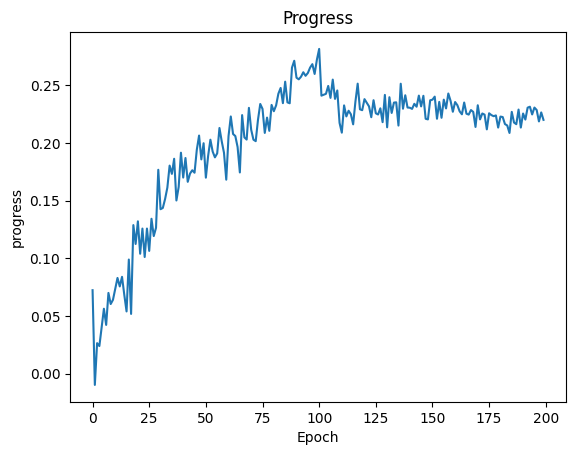

In [ ]:
plt.title('Progress')
plt.xlabel('Epoch')
plt.ylabel('progress')
plt.plot(progress)

In [ ]:
actions = []

for j in range(WINDOW_SHAPE, len(df['CLOSE']), REWARD_TIME):
    # 1. We obtain derivatives in a separate interval
    # Current price and previous WINDOW_SHAPE steps
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # We get the prediction of the bot according to the data
    q_value_j = agent.get_value_action_value(state_j)
    # We define the signal and record it in events
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

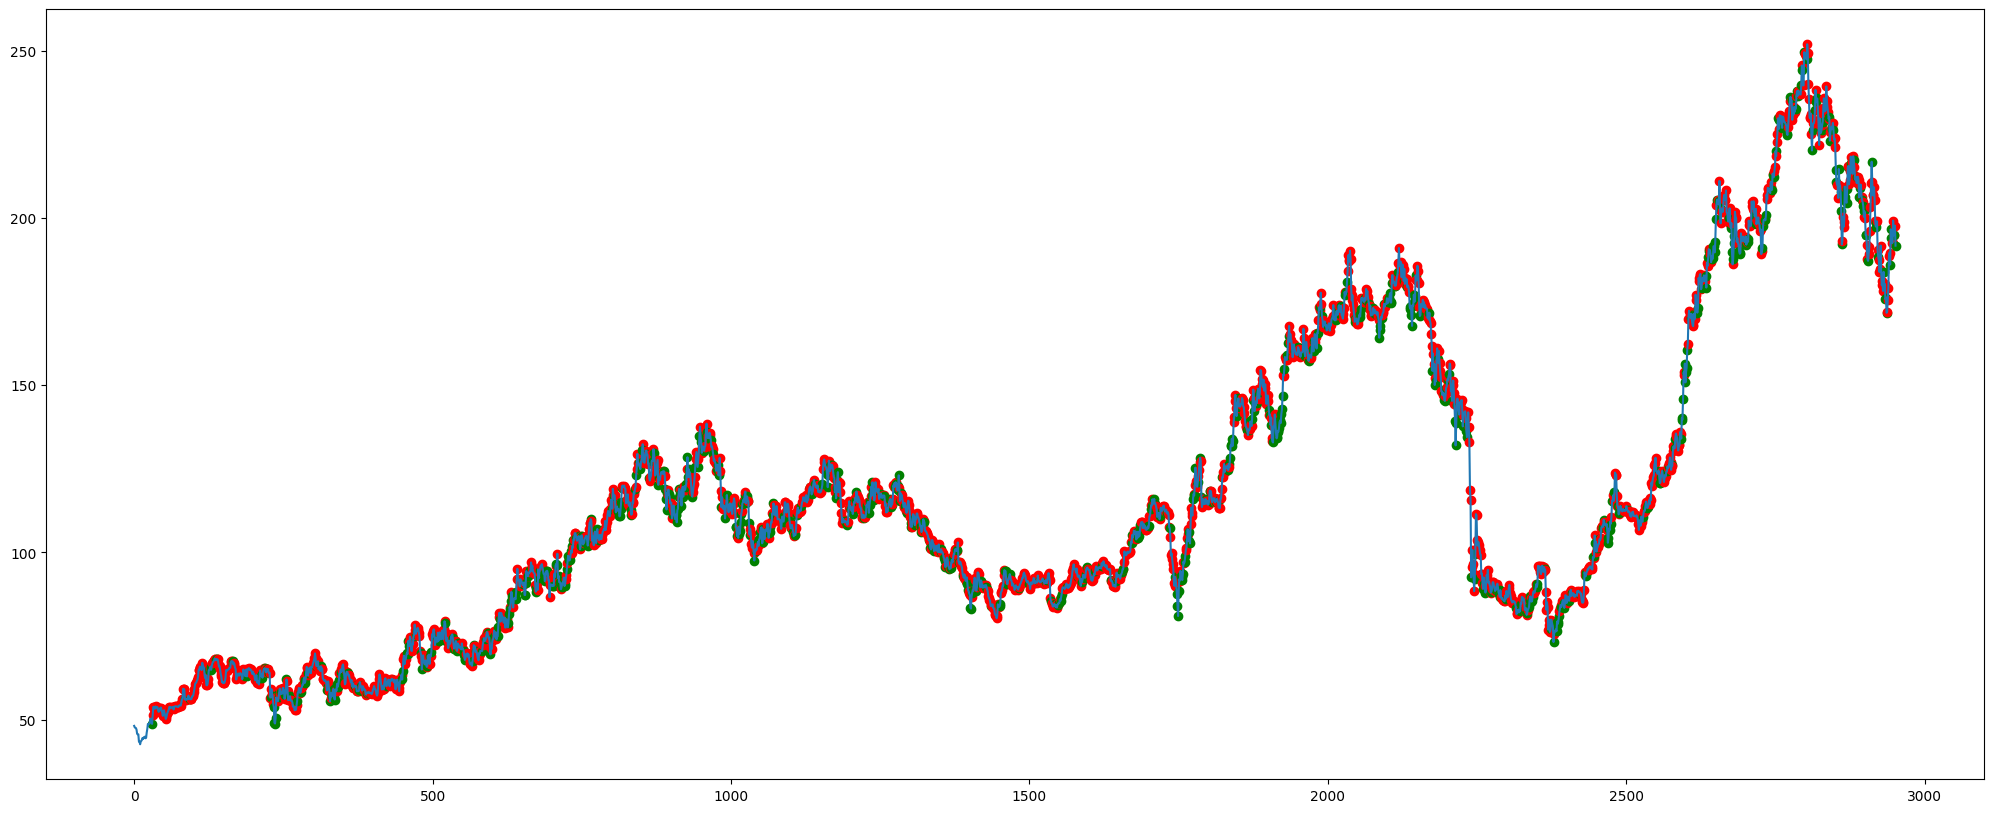

In [ ]:
plt.figure(figsize = (25, 10))
dataf = environment.data[::REWARD_TIME]
plt.plot(dataf)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE//REWARD_TIME
    if a == 1:
        plt.scatter(e, dataf[e], color = 'green')
    elif a == -1:
        plt.scatter(e, dataf[e], color = 'red')

plt.show()

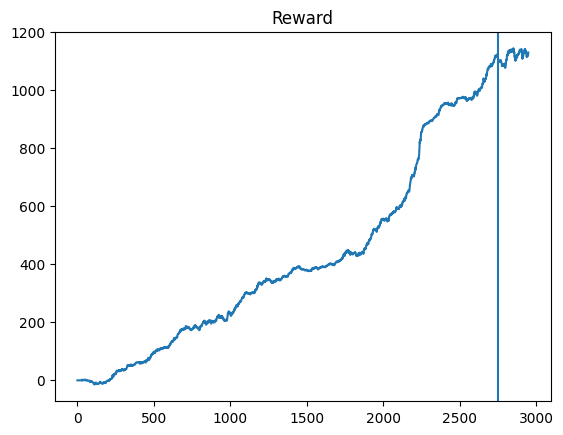

In [ ]:
 # We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()

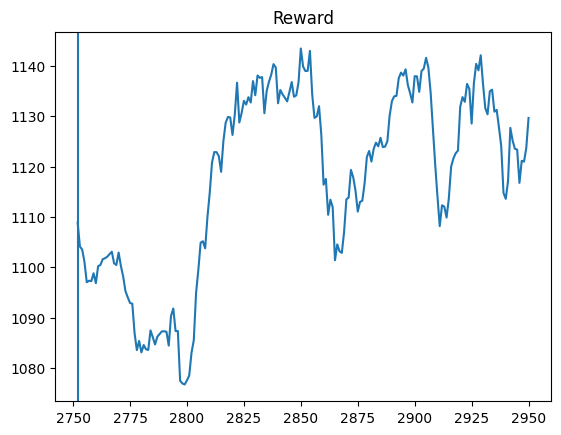

In [ ]:
# We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum()[-200:].plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()